# Imports and Setup

In [1]:
import argparse
import glob
import os
import random
import re
import pandas as pd
import numpy as np
import csv
import json
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import collections

from tqdm.auto import tqdm
import pickle

from string2string.alignment import NeedlemanWunsch
from string2string.misc.plotting_functions import plot_pairwise_alignment


%load_ext autoreload
%autoreload 2

In [2]:
# Spacy setup. Need to be done once.
!pip -q install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!pip install plotly
!pip install string2string
## !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 18.4 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [3]:
import spacy
from spacy.lang.es.examples import sentences 
from spacy import displacy

print(spacy.__version__)
print(pd.__version__)

from nltk.parse import stanford, corenlp
NLP_ES = spacy.load("es_core_news_sm")
NLP_EN = spacy.load("en_core_web_sm")

3.7.2
1.4.2


In [4]:
from utils import Config
args = Config()

In [5]:
# Helper methods
def add_neighbors_of(idx, cur_order, words, id_to_head, head_to_ids):
    if idx is None:
        # Handle edge case where we do not have an index to work with.
        return
    if cur_order > 3:
        # We are only interesting in the first three orders of dependency:
        #  1 - self
        #  2 - immediate neighbors and 
        #  3 - 1-skip neighbors
        return
    if f'{idx}' in words:
        # Node has been processed already
        return
    if idx not in id_to_head:
        # The current index does not identify a word in the corrected sentence.
        # This can happen as the correction index holds indices into string with both 
        # versions (corrected and uncorrected) appended.
        return

    # Add current index and its order to the dict
    words[f'{idx}'] = cur_order
    
    # Process head of current index
    upstream = id_to_head[idx]
    add_neighbors_of(upstream, cur_order + 1, words, id_to_head, head_to_ids)

    # Process words that are immediately downstream of current index
    if idx in head_to_ids:
        downstream = head_to_ids[idx]
        [add_neighbors_of(down_idx, cur_order + 1, words, id_to_head, head_to_ids) for down_idx in downstream]
    

def dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    if len(correction_index) == 0:
        return dict()
    
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict()
    head_to_ids = dict()
    for token in js_str["tokens"]:
        id = token["id"]
        head = token["head"]
        if token['pos'] != 'PUNCT':
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

    pred_parse_order = dict(sorted(pred_parse_order.items()))
    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

In [6]:
# Define class id mappers
classes_ids = {
    'article': 'az',
    'gender agreement': 'ga',
    'gender and number agreement': 'ga-na',
    'number agreement': 'na'
}

# Load Data and do Sanity Tests

## Sanity on Full Data

In [7]:
def load():
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/final.csv", index_col=None, header=0)
    # The srouce, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    
    df['evidence_index'] = np.empty((len(df), 0)).tolist()
    df['predicted_parsing_order'] = ""
    df['origin'] = 'A'
    return df

df_raw = load()

In [8]:
# Check the columns
df_raw.columns

Index(['Unnamed: 0', 'paragraph_id', 'sentence_id', 'course', 'essay_new',
       'annotated_sentence', 'anno_error_cnt', 'full_error_tag', 'order_tag',
       'error_tag', 'correction', 'error', 'target', 'correction_index',
       'error_type', 'source', 'new_error_type', 'evidence_index',
       'predicted_parsing_order', 'origin'],
      dtype='object')

In [9]:
# All rows should have an error_type
df_raw[df_raw.error_type.isnull()]

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,error_tag,correction,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin


In [10]:
# Check for null values
df_raw[df_raw.notnull()].count()

Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
dtype: int64

In [11]:
df_raw.isna().sum()

Unnamed: 0                   0
paragraph_id                 0
sentence_id                  0
course                       0
essay_new                    0
annotated_sentence           0
anno_error_cnt               0
full_error_tag               0
order_tag                    0
error_tag                    0
correction                  49
error                      414
target                       0
correction_index             0
error_type                   0
source                       0
new_error_type               0
evidence_index               0
predicted_parsing_order      0
origin                       0
dtype: int64

In [12]:
df_raw.sample(n=5)

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,error_tag,correction,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin
5158,27,851,23e425bc465603249d67cdf91e660f2e9d61427124f83c...,SPA 2,Yo compro alugunas de su maquillaje.,Yo compro [alugunas]{algunos}<ga:mf:det:inan> ...,3,[su]{sus}<na:ps:det:inan>,1,na:ps:det:inan,sus,su,"[Yo, compro, algunos, de, sus, maquillajes, .]","[4, 12]",na:ps,"[Yo, compro, algunos, de, su, maquillajes, .]",number agreement,[],,A
757,159,245,fb2b65f6336d3d2072c095b45568ce0ab7b7d53f939358...,SPA 2,Es su primero parte en una media.,Es su [primero]{primera}<ga:fm:adj:inan> parte...,1,[primero]{primera}<ga:fm:adj:inan>,0,ga:fm:adj:inan,primera,primero,"[Es, su, primera, parte, en, una, media, .]","[2, 11]",ga:fm,"[Es, su, primero, parte, en, una, media, .]",gender agreement,[],,A
4265,613,1063,59509489e560ee33e6267c58ca1a2674543d8e7a3133cb...,SPA 3,despues vamos a caminar por el calles del pueb...,despues vamos a caminar por [el]{las}<ga:na:fm...,2,[el]{las}<ga:na:fm:ps:det:inan>,0,ga:na:fm:ps:det:inan,las,el,"[despues, vamos, a, caminar, por, las, calles,...","[5, 28]",ga:na:fm:ps,"[despues, vamos, a, caminar, por, el, calles, ...",gender and number agreement,[],,A
4479,716,1195,1293eaa07cd4eba1d2074fec161b6dc74b0b1fb000c711...,SPA 3,Los Angeles es el ciudad moderno y grande.,Los Angeles es [el]{la}<ga:fm:det:inan> ciudad...,2,[moderno]{moderna}<ga:fm:adj:inan>,1,ga:fm:adj:inan,moderna,moderno,"[Los, Angeles, es, la, ciudad, moderna, y, gra...","[5, 15]",ga:fm,"[Los, Angeles, es, la, ciudad, moderno, y, gra...",gender agreement,[],,A
3773,406,676,721e1307e120ddf4435f2bcf8d40fe983feb0cdc58f23b...,SPA 2,Su amigas es muy divertida.,[Su]{sus}<na:ps:det:an> amigas es muy [diverti...,2,[divertida]{divertidas}<na:ps:adj:an>,1,na:ps:adj:an,divertidas,divertida,"[sus, amigas, es, muy, divertidas, .]","[4, 11]",na:ps,"[sus, amigas, es, muy, divertida, .]",number agreement,[],,A


## Split Dataset into With Errors and Without Errors

In [77]:
# Split dataset into two dataframes one with errors and one without
def split_on_error(df):
    df_no_errors = df.query('error_type == "None"').copy()
    df_no_errors.reset_index(inplace=True)
    df_no_errors.rename(columns={'index': "orig_index"}, inplace=True)
    df_errors = df.query('error_type != "None"').copy()
    df_errors['orig_error_type'] = df_errors['error_type']
    df_errors['error_type'] = df_errors['new_error_type']

    df_errors.reset_index(inplace=True)
    df_errors.rename(columns={'index': "orig_index"}, inplace=True)
    return df_errors, df_no_errors

df_errors, df_no_errors = split_on_error(df_raw)

In [78]:
# df_errors.to_csv(args.PROCESSED_DATA_FOLDER + "/final_with_errors.csv", index=False)

In [79]:
df_errors.index[(df_errors.essay_new == 'Entonces será certificado como “perfecto".')]

Int64Index([5221, 5222], dtype='int64')

In [80]:
df_errors[df_errors.notnull()].count()

orig_index                 5223
Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
orig_error_type            5223
dtype: int64

In [81]:
df_no_errors[df_no_errors.notnull()].count()

orig_index                 0
Unnamed: 0                 0
paragraph_id               0
sentence_id                0
course                     0
essay_new                  0
annotated_sentence         0
anno_error_cnt             0
full_error_tag             0
order_tag                  0
error_tag                  0
correction                 0
error                      0
target                     0
correction_index           0
error_type                 0
source                     0
new_error_type             0
evidence_index             0
predicted_parsing_order    0
origin                     0
dtype: int64

In [82]:
df_errors.full_error_tag.unique()

array(['[]{a}<az:do:an>', '[a]{}<za:do:inan>', '[al]{al}<aa:do:an>', ...,
       '[fresco]{frescos}<na:ps:adj:inan>',
       '[encurtido]{encurtidos}<na:ps:adj:inan>',
       '[certificado]{certificadas}<ga:fm:adj:inan>'], dtype=object)

In [83]:
df_errors.error_type.unique()

array(['article', 'number agreement', 'gender agreement',
       'gender and number agreement'], dtype=object)

In [84]:
# # Reduce the number of error classes to 4 - ga, na, ga-na and az.
# error_map = {
# 'aa:do': 'az',
# 'az:do': 'az',
# 'za:do': 'az',
# 'aa:io': 'az',
# 'az:io': 'az',
# 'na:ps': 'na',
# 'ga:fm': 'ga',
# 'ga:mf:det:aty': 'ga',
# 'ga:mf': 'ga',
# 'ig:f': 'na',
# 'na:sp': 'na',
# 'in:s': 'na',
# 'ga:na:fm:ps': 'ga-na',
# 'ga:fm:det:aty': 'ga',
# 'ga:ps': 'ga',
# 'ig:e': 'na',
# 'ig:m': 'na',
# 'ga:na:mf:ps': 'ga-na',
# 'ga:mf:noun:aty': 'ga',
# 'ga:mf:adj:aty': 'ga',
# 'ga:na:fm:sp': 'ga-na',
# 'ga:na:mf:sp': 'ga-na',
# 'in:p': 'na',
# 'ga:fm:adj:aty': 'ga',
# 'ga:fm:noun:aty': 'ga',
# 'ig:in:f:s': 'na',
# 'ga:fm:gat:noun': 'ga',
# 'in:p:gat:noun': 'na',
# 'na:sp:gat:noun': 'na',
# 'ga:mf:pron:aty': 'ga',
# 'in:s:gat:noun': 'na',
# 'ga': 'ga'}

# df_errors['error_type'] = df_errors.apply(lambda row: error_map[row.orig_error_type], axis=1)

In [85]:
df_errors.error_type.value_counts()

gender agreement               2995
number agreement               1460
article                         477
gender and number agreement     291
Name: error_type, dtype: int64

## Fix Data Issues

### Handle Non-breaking Space Character

In [86]:
# Some of the sentences have non-breaking space ('\xa0') which breaks dependency tree logic.
# Count number of lines with non-breaking space in them
def cleanup_nbsp(df):
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces before cleanup.")
    df.essay_new = df.essay_new.str.replace('\xa0', ' ')
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces after cleanup.")
    return df

df_errors = cleanup_nbsp(df_errors)

273 rows have non-breaking spaces before cleanup.
0 rows have non-breaking spaces after cleanup.


### Handle Newline Characters

In [87]:
# Some of the sentences have new line characters which breaks dependency tree logic.
def cleanup_new_line(df):
    rows = df[(df.essay_new.str.contains(r'\n+'))]
    print(f"{rows.shape[0]} rows have new line before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    df.essay_new = df.essay_new.str.replace('\n', ' ')
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    rows = df[(df.essay_new.str.contains('\n'))]
    print(f"{rows.shape[0]} rows have double spaces after cleanup.")
    return df

df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_new_line(df_errors)

72 rows have new line before cleanup.
Few samples before cleanup:
5187    \n\nPor la próxima tres días, vamos a Disneyla...
1848    \n\nTraería mucho dinero para comprar la ropa ...
3826    A la fin de película, ella lastimó la protagon...
4653     \n\n"Una vacacion perfecta"\nMi vacacíon perf...
4900    Mi Vacación Ideal\n\nMi vacación ideal es en H...
1911    \n\nQuiero ver fashion shows de diseñadoras fa...
5217    Llevaria mi familia al Museo Nacional para mir...
4894    Una Vacación Perfecta\n\nUn mes antes de comen...
4850     \n\nEste es mi vacación perfecto - \n\nEl pri...
4209    \n\nPor la próxima cuatro días, vamos a pasar ...
Name: essay_new, dtype: object

Same entries after cleanup:
5187      Por la próxima tres días, vamos a Disneylandia.
1848      Traería mucho dinero para comprar la ropa y ...
3826    A la fin de película, ella lastimó la protagon...
4653       "Una vacacion perfecta" Mi vacacíon perfect...
4900    Mi Vacación Ideal  Mi vacación ideal es en Haw...
1911

### Handle Double Space Characters

In [88]:
# Some of the sentences have multiple spaces which breaks dependency tree logic.
# Count number of lines with multiple spaces in them
def cleanup_double_spaces(df):
    rows = df[(df.essay_new.str.contains(r'\s\s+'))]
    print(f"{rows.shape[0]} rows have double spaces before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    # df.essay_new = df.essay_new.str.replace('  ', ' ')

    df.essay_new = df.essay_new.str.replace(r'\s+', ' ', regex=True).str.strip()
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    print(f"{df[(df.essay_new.str.contains('  '))].shape[0]} rows have double spaces after cleanup.")
    return df

# df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_double_spaces(df_errors)

139 rows have double spaces before cleanup.
Few samples before cleanup:
1153               Yo no puedo cantar pero quiero ser ...
4225       Por mi perfecto vacaciones yo quiero ir Haw...
1546               Sinclair empezó la profesión de act...
2649    La clima en Hawaii es muy templado con mucho  ...
1078                              Ella también es  actor.
1587    Bruno Mars tiene el pelo negra y los ojos marr...
1793    Necesito  a pedir tiempo de vacación para mi e...
1472            Demi no tiene  novio porque está ocupado.
1438    Todo lo llaman Dr. Love o Hug Doctor  Escribe ...
2457        Adicionalmente, Europa es muy rico en hist...
Name: essay_new, dtype: object

Same entries after cleanup:
1153    Yo no puedo cantar pero quiero ser un persona ...
4225    Por mi perfecto vacaciones yo quiero ir Hawaii...
1546    Sinclair empezó la profesión de actor a las si...
2649    La clima en Hawaii es muy templado con mucho s...
1078                               Ella también es actor

In [90]:
df_errors.iloc[[1078, 1472]].essay_new

1078                      Ella también es actor.
1472    Demi no tiene novio porque está ocupado.
Name: essay_new, dtype: object

### Sanity Check Lines with Errors

In [91]:
def compute_status(row):
    num_len_mismatch = 0
    num_extra_corrections = 0
    source = row.source
    target = row.target
    correction_index = set(row.correction_index)
    row_status = 'GOOD'
    if len(source) != len(target):
        num_len_mismatch = num_len_mismatch + 1
        row_status = 'LEN_MISMATCH'
    else:
        mismatches = map(lambda x: x[0] == x[1], zip(source, target))
        for (i, flag) in enumerate(mismatches):
            if not flag and i not in correction_index:
                # print('Extra corrections')
                num_extra_corrections = num_extra_corrections + 1
                row_status = 'EXTRA_CORRECTIONS'
                break
    return row_status

def check_errors():
    df_status = df_errors[['orig_index', 'sentence_id', 'essay_new', 'source', 'target', 'correction_index']].copy(deep=True)
    df_status['status'] = df_status.apply(compute_status, axis=1)
    df_status['has_annotation'] = df_status.apply(lambda row: '<' in row.source or '<' in row.target, axis=1)
    return df_status
    
df_error_status = check_errors()

In [92]:
print('Should have just GOOD rows')
print(df_error_status.status.value_counts())

print()
print('Should not have annotations')
print(df_error_status.has_annotation.value_counts())

with pd.option_context('display.max_colwidth', None):
    display(df_error_status[df_error_status['status'] == 'EXTRA_CORRECTIONS'])
    print("----------------------")
    display(df_error_status[df_error_status.has_annotation == True])

Should have just GOOD rows
GOOD    5223
Name: status, dtype: int64

Should not have annotations
False    5223
Name: has_annotation, dtype: int64


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


----------------------


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


In [93]:
# Check on alignment logic to ensure that all lines in the error dataset can be aligned
def is_same(list1, list2):
    if len(list1) != len(list2):
        return False
    
    for v1, v2 in zip(list1, list2):
        if v1.strip() != v2.strip():
            return False
        
    return True
        
def print_context(row):
    print(f'error_type: {row.error_type} => {row.new_error_type}')

def alignment_sanity(df, context_printer=None, verbosity=0):
    mismatches = 0
    for i, row in df.iterrows():
        nw = NeedlemanWunsch()
        aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
        path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
        if not (is_same(row.source, s1_pieces) and is_same(row.target, s2_pieces)):
            mismatches = mismatches + 1
            if verbosity > 0:
                print('----------------------------------------------')
                if context_printer:
                    context_printer(row)
                print(f"Original: \n=>{row.source}\n=>{row.target}")
                print(f'Correction index: {row.correction_index}')
                print(f'Path:\n{path}\n===>{s1_pieces}, \n===>{s2_pieces}')

    print('----------------------------------------------')
    return mismatches

print(f'Lower number of mismatches is better with 0 being ideal')
print(f"Number of mismatches in COWS-L2H dataset: {alignment_sanity(df_errors)}/{df_errors.shape[0]}")


Lower number of mismatches is better with 0 being ideal
----------------------------------------------
Number of mismatches in COWS-L2H dataset: 0/5223


In [94]:
print(f'Distribution of number of elements in correction count')
print(df_errors.correction_index.map(lambda v: len(v)).value_counts())
print('')
print(f'Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.')


Distribution of number of elements in correction count
2    5223
Name: correction_index, dtype: int64

Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.


# Explore EXPECT dataset

In [175]:
def load_expect_data(num_lines=None):
    expect_train_file = f"{args.EXPLAINABLE_GEC_DATA_FOLDER}/train.json"
    with open(expect_train_file, "r") as file1:
        count = 0
        rows = file1.readlines()
        df = pd.DataFrame([eval(row) for row in rows])
        df['source_org'] = df.source.map(lambda v: ' '.join(v).replace(" .", "."))        
        df['target_org'] = df.target.map(lambda v: ' '.join(v).replace(" .", "."))
        return df

df_expect = load_expect_data()


In [176]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.sample(5))

,target,source,evidence_index,correction_index,error_type,predicted_parsing_order,origin,source_org,target_org
4320,"[This, story, is, about, a, murderer, who, completes, his, mission, :, killed, everyone, that, he, hated, .]","[This, story, was, about, a, murderer, who, completes, his, mission, :, killed, everyone, that, he, hated, .]","[7, 25]","[2, 20]",Verb Tense,"{'2': 1, '5': 2, '20': 1, '23': 2}",A,This story was about a murderer who completes his mission : killed everyone that he hated.,This story is about a murderer who completes his mission : killed everyone that he hated.
14155,"[In, surveys, ,, it, was, asked, if, consumers, would, rather, buy, branded, products, or, no, -, name, products, .]","[In, surveys, ,, it, was, asked, if, consumers, would, rather, buy, brand, products, or, no, -, name, products, .]","[12, 32]","[11, 31]",POS Confusion,"{'10': 3, '11': 1, '12': 2, '30': 3, '31': 1, '32': 2}",C,"In surveys , it was asked if consumers would rather buy brand products or no - name products.","In surveys , it was asked if consumers would rather buy branded products or no - name products."
9816,"[I, write, down, new, French, vocabulary, or, grammar, in, my, notebook, .]","[I, write, down, new, French, vocabularies, or, grammar, in, my, notebook, .]","[3, 4, 16, 17]","[5, 18]",Number,"{'2': 3, '4': 2, '5': 1, '6': 2, '7': 2, '8': 2, '10': 3, '15': 3, '17': 2, '18': 1, '19': 2, '20': 2, '21': 2, '23': 3}",B,I write down new French vocabularies or grammar in my notebook.,I write down new French vocabulary or grammar in my notebook.
13377,"[Lee, 2014, defines, three, methods, of, self, -, presentation, in, most, social, media, :, 1, "", online, profile, "", p., 97, ,, that, is, the, "", entry, point, to, social, networking, "", .]","[Lee, 2014, defines, three, ways, of, self, -, presentation, in, most, social, media, :, 1, "", online, profile, "", p., 97, ,, that, is, the, "", entry, point, to, social, networking, "", .]",[],"[4, 38]",Collocation,"{'2': 2, '3': 2, '4': 1, '5': 2, '7': 3, '9': 2, '11': 3, '12': 2, '13': 2, '19': 3, '22': 3, '36': 2, '37': 2, '38': 1, '39': 2, '41': 3, '43': 2, '45': 3, '46': 2, '47': 2, '53': 3, '56': 3}",C,"Lee 2014 defines three ways of self - presentation in most social media : 1 "" online profile "" p. 97 , that is the "" entry point to social networking "".","Lee 2014 defines three methods of self - presentation in most social media : 1 "" online profile "" p. 97 , that is the "" entry point to social networking ""."
4789,"[Once, technology, and, the, standard, of, living, are, improved, ,, many, people, left, the, traditional, habit, of, using, public, transportation, and, chose, the, car, for, several, reasons, .]","[Once, technology, and, the, standard, of, living, are, improved, ,, many, people, left, the, traditional, habit, of, using, public, transportation, and, choosing, car, for, several, reasons, .]",[],"[21, 22, 50]",Others,"{'1': 3, '4': 2, '12': 2, '21': 1, '22': 1, '23': 2, '24': 2, '26': 3, '27': 3, '30': 3, '33': 2, '41': 2, '50': 1, '51': 2, '52': 2, '54': 3, '55': 3}",A,"Once technology and the standard of living are improved , many people left the traditional habit of using public transportation and choosing car for several reasons.","Once technology and the standard of living are improved , many people left the traditional habit of using public transportation and chose the car for several reasons."


In [177]:
df_expect.isna().sum()

target                     0
source                     0
evidence_index             0
correction_index           0
error_type                 0
predicted_parsing_order    0
origin                     0
source_org                 0
target_org                 0
dtype: int64

## Dependency parsing tree on EXPECT

In [178]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.iloc[11872])

target                                 [The, periodic, movement, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
source                                     [The, periodic, move, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
evidence_index                                                                                                                      [0, 1, 18, 19]
correction_index                                                                                                                           [2, 20]
error_type                                                                                                                           POS Confusion
predicted_parsing_order    {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}
origin                                                                                                                

In [179]:
def show_one_EXPECT(nlp, row_idx):
    row = df_expect.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.target_org, row.correction_index, verbosity=1)
    print()
    print(f'Orig: {row.source_org}')
    print(f'Corr: {row.target_org}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print(f'Corr: {row.target_org}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

# show_one_EXPECT(11872)
show_one_EXPECT(NLP_EN, 1314)
    

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 2, '3': 3}


In [180]:
print("Evidence words are important for GEC")
print(f'computed pred_parse_order: {dep_parsing_tree(spacy.load("en_core_web_sm"), "Evidence words are important for GEC", [2])}')


Evidence words are important for GEC
computed pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '5': 3}


In [181]:
show_one_EXPECT(NLP_EN, 11872)

id -> head: {0: 2, 1: 2, 2: 7, 3: 2, 4: 6, 5: 6, 6: 3, 7: 7, 8: 7, 9: 11, 10: 11, 11: 8, 12: 11, 13: 15, 14: 15, 15: 12}
head -> ids: {2: [0, 1, 3], 7: [2, 7, 8], 6: [4, 5], 3: [6], 11: [9, 10, 12], 8: [11], 15: [13, 14], 12: [15]}



Orig: The periodic move of the minute hand compared to the smooth path of the second hand.
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.
Concatenated: ['The', 'periodic', 'move', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.', 'SEP', 'The', 'periodic', 'movement', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.']
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.

Correction index: [2, 20]

Corrected offset: 18
Original pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}

computed pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '6': 3, '7': 2, '8': 3}


In [182]:
show_one_EXPECT(NLP_EN, 1289)

id -> head: {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 6, 6: 4}
head -> ids: {1: [0], 2: [1, 2, 3, 4], 6: [5], 4: [6]}



Orig: The waiter come and took the order.
Corr: The waiter came and took the order.
Concatenated: ['The', 'waiter', 'come', 'and', 'took', 'the', 'order', '.', 'SEP', 'The', 'waiter', 'came', 'and', 'took', 'the', 'order', '.']
Corr: The waiter came and took the order.

Correction index: [2, 11]

Corrected offset: 9
Original pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3, '7': 2, '9': 3, '10': 2, '11': 1, '12': 2, '13': 2, '15': 3, '16': 2}

computed pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3}


In [183]:
print(f"Number of mismatches in EXPECT dataset: {alignment_sanity(df_expect)}/{df_expect.shape[0]}")

----------------------------------------------
Number of mismatches in EXPECT dataset: 1617/15187


# Process COWS-L2H Data

## Understand Issues With Dependency Parse Tree

In [95]:
def check_dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    if len(correction_index) == 0:
        return dict()
    ignored = set(['PUNCT'])
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict()
    head_to_ids = dict()
    for token in js_str["tokens"]:
        # print(token)
        id = token["id"]
        head = token["head"]
        if token['pos'] not in ignored:
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

    pred_parse_order = dict(sorted(pred_parse_order.items()))
    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

def check(df, idx):
    row = df.iloc[idx]
    print(f'{idx}: {row.essay_new}')
    return check_dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=2)

[print(check(df_errors, idx)) for idx in [2238, 4360, 4361]]


2238: Mi lugar favorito es *CITY* en *STATE* Mexico.
id -> head: {0: 1, 1: 5, 2: 1, 3: 5, 4: 5, 5: 5, 6: 5, 7: 9, 8: 9, 9: 5, 10: 5, 11: 5}
head -> ids: {1: [0, 2], 5: [1, 3, 4, 5, 6, 9, 10, 11], 9: [7, 8]}


{'1': 3, '10': 3, '11': 3, '3': 3, '4': 1, '5': 2, '6': 3, '9': 3}
4360: Yo quiere que nosotros vayamos a la playas y el mar aquí y nademos en la aqua.
id -> head: {0: 1, 1: 1, 2: 4, 3: 4, 4: 1, 5: 7, 6: 7, 7: 4, 8: 10, 9: 10, 10: 7, 11: 4, 12: 13, 13: 4, 14: 16, 15: 16, 16: 13}
head -> ids: {1: [0, 1, 4], 4: [2, 3, 7, 11, 13], 7: [5, 6, 10], 10: [8, 9], 13: [12, 16], 16: [14, 15]}


{'10': 3, '4': 3, '5': 3, '6': 1, '7': 2}
4361: Yo quiere que nosotros vayamos a la playas y el mar aquí y nademos en la aqua.
id -> head: {0: 1, 1: 1, 2: 4, 3: 4, 4: 1, 5: 7, 6: 7, 7: 4, 8: 10, 9: 10, 10: 7, 11: 4, 12: 13, 13: 4, 14: 16, 15: 16, 16: 13}
head -> ids: {1: [0, 1, 4], 4: [2, 3, 7, 11, 13], 7: [5, 6, 10], 10: [8, 9], 13: [12, 16], 16: [14, 15]}


{'13': 3, '14': 3, '15': 1, '16': 2}


[None, None, None]

## Add First and Second Order Dependencies

### First and Second Order Dependencies for Target

In [96]:
def COWSL2H_parsing_order(nlp, df, row_idx):
    row = df.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.essay_new, row.correction_index, verbosity=2)
    print('-----------------------------------------------')
    print
    print()
    print(f'Orig: {" ".join(row.source)}')
    print(f'Corr: {row.essay_new}')
    print(f'row.source: {row.source}')
    print(f'row.target: {row.target}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

In [97]:
%%time
def count_by_order(row, order_req):
    count = 0
    for (idx, cur_order) in row.predicted_parsing_order.items():
        if cur_order == order_req:
            count = count + 1
    return count

def add_target_dependencies(df):
    def add_parsing_order(row):
        return dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=0)        
    df['predicted_parsing_order'] = df.apply(add_parsing_order, axis=1)
    df['parsing_order_len'] = df_errors.apply(lambda row: len(row.predicted_parsing_order), axis=1)
    df['num_first_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 2), axis=1)
    df['num_second_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 3), axis=1)

add_target_dependencies(df_errors)

CPU times: user 19.9 s, sys: 84.2 ms, total: 20 s
Wall time: 20 s


### First and Second Order Dependencies for Source

In [98]:
def add_source_parsing_order(row, verbosity=0):
    nw = NeedlemanWunsch()
    aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
    path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
    path_as_dict = dict(path)
    if verbosity > 0:
        print(row.sentence_id, path_as_dict, s1_pieces, s2_pieces)
    pred_parsing_order = row.predicted_parsing_order.copy()
    
    if verbosity > 0:
        print(row.predicted_parsing_order)
    src_offset = len(row.target) + 1
    for idx, dependency_num in row.predicted_parsing_order.items():
        if dependency_num == 1:
            pred_parsing_order[f'{row.correction_index[1]}'] = 1
        elif dependency_num == 2 or dependency_num == 3:
            if verbosity > 0:
                print(int(idx), dependency_num)
            if int(idx) not in path_as_dict:
                print(f'Logic is failing for row {row}')
                return None
            pred_parsing_order[f'{path_as_dict[int(idx)] + src_offset}'] = dependency_num
    return pred_parsing_order

def add_source_dependencies(df):
    # print(add_source_parsing_order(df.iloc[473], verbosity=1) )
    df['new_predicted_parsing_order'] = df.apply(add_source_parsing_order, axis=1)

add_source_dependencies(df_errors)

Logic is failing for row orig_index                                                                    2238
Unnamed: 0                                                                     754
paragraph_id                                                                  1241
sentence_id                      7d41323560f6726aeaa1667d58a3f6a2e06b6c62214761...
course                                                                       SPA 3
essay_new                           Mi lugar favorito es *CITY* en *STATE* Mexico.
annotated_sentence               Mi lugar favorito es [Puerta]{puerto}<ig:f:nou...
anno_error_cnt                                                                   1
full_error_tag                                    [Puerta]{puerto}<ig:f:noun:inan>
order_tag                                                                        0
error_tag                                                           ig:f:noun:inan
correction                                                    

In [72]:
df_errors.new_predicted_parsing_order.isna().sum()

1

In [105]:
for item in df_errors[df_errors.essay_new.str.contains('\*')].essay_new.items():
    print(f'{item[0]}:{item[1]}')

237:* No hay mucho que hacer en Antartica, pero me gustaría ir a ver pingüinos y solo para poder decir que fui.
245:Me llevaría mi mejor amigo se llama *FIRST_NAME*.
246:Sí trajiera con alguien, traería mi hermano *FIRST_NAME* porque el es muy inteligente.
257:Si tuviera que llevar a alguien sería mi primo *FIRST_NAME* y mi amigo *FIRST_NAME*.
288:Nosotros visitamos su familia en *CITY*, *STATE*.
289:En verano nos gusta visitar mi madre en *STATE*.
290:Nosotros visitamos ellos y vamos a el zoo en *CITY*.
333:Durante ese semana, montaria los cabellos por la playa y el mar tambien, y veria una pelicula en espanol en el cine de *CITY*.
400:Mi visité *FIRST_NAME* en la verano.
615:Por ejemplo, uno de sus estudiantes quien se llama *FIRST_NAME* *LAST_NAME* era el alcalde de mi ciudad natal, *CITY*, y sus otro estudiante era el principio de la universidad de *CITY*.
674:En Marzo viente siete, yo y mi amiga *FIRST_NAME* fuimos su Dangerous Woman concerté!
914:Hoy, hay muchas estudiantes que e

In [73]:
df_errors[df_errors.new_predicted_parsing_order.isna()]

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len,num_first_order_dependencies,num_second_order_dependencies,new_predicted_parsing_order
2238,2238,754,1241,7d41323560f6726aeaa1667d58a3f6a2e06b6c62214761...,SPA 3,Mi lugar favorito es *CITY* en *STATE* Mexico.,Mi lugar favorito es [Puerta]{puerto}<ig:f:nou...,1,[Puerta]{puerto}<ig:f:noun:inan>,0,...,"[Mi, lugar, favorito, es, Puerta, Vallarta, en...",gender agreement,[],"{'1': 3, '10': 3, '11': 3, '3': 3, '4': 1, '5'...",A,ig:f,8,1,6,None


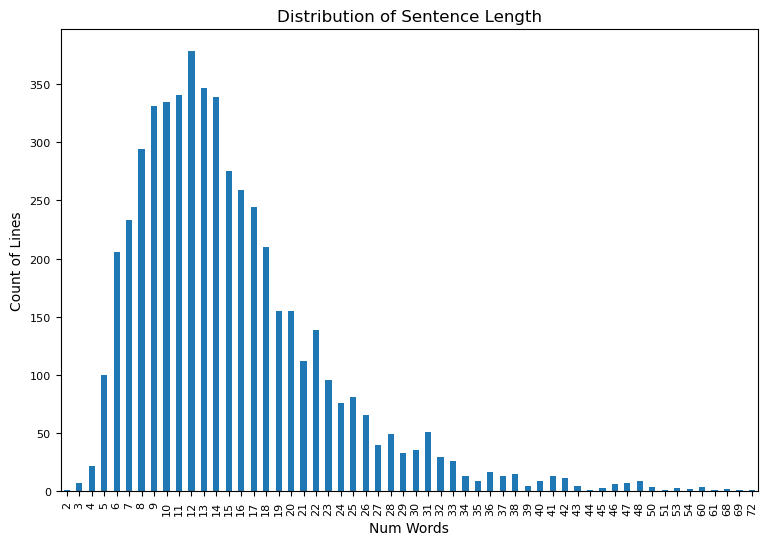

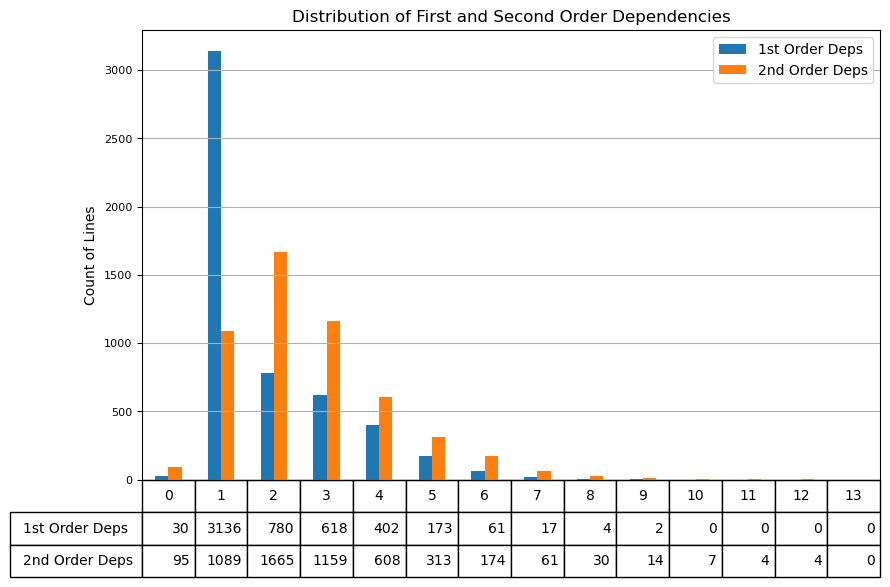

CPU times: user 1.43 s, sys: 705 ms, total: 2.13 s
Wall time: 472 ms


In [75]:
%%time
# Plot the data
def build_df_dependencies(df):
    df_dependencies = pd.DataFrame({'Num Dependencies':list(range(0, 14))})
    df_dependencies['1st Order Deps'] = 0
    df_dependencies['2nd Order Deps'] = 0
    df_first_order =  df['First Order Dependencies'].value_counts().sort_index(axis=0)
    df_second_order =  df['Second Order Dependencies'].value_counts().sort_index(axis=0)
    for num_dependencies, count in df_first_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '1st Order Deps'] = count
    for num_dependencies, count in df_second_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '2nd Order Deps'] = count
    return df_dependencies

def build_dfs(df):
    df_plot = pd.DataFrame()
    df_plot['Sentence Len'] = df.apply(lambda row: len(row.target), axis=1)
    df_plot['Parsing Order Len'] = df.apply(lambda row: len(row.predicted_parsing_order), axis=1)
    df_plot['First Order Dependencies'] = df.apply(lambda row: count_by_order(row, 2), axis=1)
    df_plot['Second Order Dependencies'] = df.apply(lambda row: count_by_order(row, 3), axis=1)
    return df_plot, build_df_dependencies(df_plot)
    
def plots(df):
    df_plot, df_dependencies = build_dfs(df)
    
    df_plot['Sentence Len'].value_counts().sort_index(axis=0).plot(
        kind='bar',
        fontsize=8,
        figsize=(9, 6),
        xlabel="Num Words",
        ylabel="Count of Lines",
        xticks = None,
        title="Distribution of Sentence Length",
    )
    plt.show()

    plot_combo = df_dependencies.plot(
        kind='bar',
        x='Num Dependencies',
        fontsize=8,
        figsize=(9, 6),
        ylabel='Count of Lines',
        title='Distribution of First and Second Order Dependencies',
        grid=True,
        table=True
    )
    plot_combo.axes.get_xaxis().set_visible(False)
    # Getting the table created by pandas and matplotlib
    table = plot_combo.tables[0]
    # Setting the font size
    table.set_fontsize(10)
    # Rescaling the rows to be more readable
    table.scale(1,2)
    plt.tight_layout()
    plt.show()
    
    # plot2 = df_plot['First Order Dependencies'].value_counts().sort_index(axis=0).plot(
    #     kind='bar',
    #     fontsize=8,
    #     figsize=(9, 6),
    #     xlabel='Num First Order Dependencies',
    #     ylabel='Count of Lines',
    #     title='Distribution of First Order Dependencies',
    #     grid=True,
    #     table=True
    # )
    # plot2.axes.get_xaxis().set_visible(False)
    # # Getting the table created by pandas and matplotlib
    # table = plot2.tables[0]
    # # Setting the font size
    # table.set_fontsize(10)
    # # Rescaling the rows to be more readable
    # table.scale(1,2)
    # plt.tight_layout()
    # plt.show()

    # plot3 = df_plot['Second Order Dependencies'].value_counts().sort_index(axis=0).plot(
    #     kind='bar',
    #     fontsize=8,
    #     figsize=(9, 6),
    #     xlabel='Num Second Order Dependencies',
    #     ylabel='Count of Lines',
    #     title='Distribution of Second Order Dependencies',
    #     grid=True,
    #     table=True)
    # plot3.axes.get_xaxis().set_visible(False)
    # # Getting the table created by pandas and matplotlib
    # table = plot3.tables[0]
    # # Setting the font size
    # table.set_fontsize(10)
    # # Rescaling the rows to be more readable
    # table.scale(1,2)
    # plt.tight_layout()
    # plt.show()

plots(df_errors)

In [76]:
# Explore the rows with empty parsing order
# TODO: explore why about 30 rows have empty parsing orders and 38 rows are missing first order dependencies.
print(f'{df_errors[df_errors.parsing_order_len == 0].shape}')
with pd.option_context('display.max_colwidth', None):
    display(df_errors[df_errors.parsing_order_len == 0])

(30, 26)


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len,num_first_order_dependencies,num_second_order_dependencies,new_predicted_parsing_order
211,211,459,775,0c66030cc2c5487d1736df818425e524874d29ada3c571b76adb1731e1015055,SPA 2,"No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer Walken también.","No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer []{a}<az:do:an> Walken también.",1,[]{a}<az:do:an>,0,...,"[No, tiene, "", oscars, "", pero, Leonardo, Dicaprio, solomente, recibió, un, oscar, el, año, pasado, ,, así, que, ., ., ., ., Pues, ,, quiero, ver, una, película, con, él, este, año, y, quiero, conocer, [NONE], Walken, también, .]",article,[],{},A,az:do,0,0,0,{'75': 1}
440,440,18,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61ae9fddbc7b5016766fc,SPA 3,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en la futuro.,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en [la]{el}<ga:mf:det:inan> futuro.,1,[la]{el}<ga:mf:det:inan>,0,...,"[Bill, and, Ted, es, de, los, dos, Bill, and, Ted, y, els, van, en, diferentes, tiempos, como, los, 1800, ’, s, o, más, patras, ., También, van, en, la, futuro, .]",gender agreement,[],{},A,ga:mf,0,0,0,{'60': 1}
475,475,37,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc3457647f571a1ba1ddbacce3,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y su música es estupendo.","Todavía me gusta escuchar ""Destiny's Child"" y su música es [estupendo]{estupenda}<ga:fm:adj:inan>.",1,[estupendo]{estupenda}<ga:fm:adj:inan>,0,...,"[Todavía, me, gusta, escuchar, "", Destiny, ', s, Child, "", y, su, música, es, estupendo, .]",gender agreement,[],{},A,ga:fm,0,0,0,{'31': 1}
480,480,40,65,139d6a79730caee9d68ad994e3fb047e5c0b6b31d42450bcf838d3943b5e33dc,SPA 3,Empezó con el grupo se llama Destiny's Child antes de realizar solo.,Empezó con el grupo se llama Destiny's Child antes de realizar [solo]{sola}<ga:fm:adj:an>.,1,[solo]{sola}<ga:fm:adj:an>,0,...,"[Empezó, con, el, grupo, se, llama, Destiny, ', s, Child, antes, de, realizar, solo, .]",gender agreement,[],{},A,ga:fm,0,0,0,{'29': 1}
874,874,201,298,d539be0f37ba2351c41b5ce478dfc7a23b8bb61a7256f29cb0bef8e2e203e25f,SPA 2,Hugh Jackman es un buen actor pero también es un buen cantante y bailarina.,Hugh Jackman es un buen actor pero también es un buen cantante y [bailarina]{bailarín}<ga:mf:noun:an>.,1,[bailarina]{bailarín}<ga:mf:noun:an>,0,...,"[Hugh, Jackman, es, un, buen, actor, pero, tambie, ́, n, es, un, buen, cantante, y, bailarina, .]",gender agreement,[],{},A,ga:mf,0,0,0,{'33': 1}
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2ae4aeaf0e32de8a6a45,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.","Me gustan muchos tipos de musica (rap, r&b,pop) , y [muchas]{muchos}<ga:mf:det:an> artistas.",1,[muchas]{muchos}<ga:mf:det:an>,0,...,"[Me, gustan, muchos, tipos, de, musica, (, rap, ,, r, &, b, ,, pop, ), ,, y, muchas, artistas, .]",gender agreement,[],{},A,ga:mf,0,0,0,{'38': 1}
1117,1117,282,412,6004f54d6469a368868a7377b03f3e9eb8d7a780202ab1862ad151095ab6e16b,SPA 3,"Después Harry Potter, J. K. Rowling ha estado muy ocupado.","Después Harry Potter, J. K. Rowling ha estado muy [ocupado]{ocupada}<ga:fm:adj:an>.",1,[ocupado]{ocupada}<ga:fm:adj:an>,0,...,"[Después, Harry, Potter, ,, J, ., K, ., Rowling, ha, estado, muy, ocupado, .]",gender agreement,[],{},A,ga:fm,0,0,0,{'27': 1}
1119,1119,282,412,a5eb6bff54851d9f5b95e8eec421ccb1e1bb16093f1ca30f076f18b93ed55080,SPA 3,"J. K. Rowling no escribía la obra, pero lo aprobó.","J. K. Ro

In [40]:
df_errors[df_errors.essay_new == 'Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.']

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len,num_first_order_dependencies,num_second_order_dependencies
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",1,[muchas]{muchos}<ga:mf:det:an>,0,...,gender agreement,"[Me, gustan, muchos, tipos, de, musica, (, rap...",gender agreement,[],{},A,ga:mf,0,0,0


In [41]:
ids_to_check = [946, 4833]
# print(df_errors.iloc[id_to_check])
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].essay_new))
for idx in ids_to_check:
    COWSL2H_parsing_order(NLP_ES, df_errors, idx)
# parsing_order = dep_parsing_tree(NLP_ES, df_errors.iloc[id_to_check].essay_new, eval(df_errors.iloc[id_to_check].correction_index), verbosity=2)


id -> head: {0: 1, 1: 1, 2: 3, 3: 1, 4: 5, 5: 3, 7: 3, 9: 7, 11: 7, 14: 16, 15: 16, 16: 1}
head -> ids: {1: [0, 1, 3, 16], 3: [2, 5, 7], 5: [4], 7: [9, 11], 16: [14, 15]}


-----------------------------------------------

Orig: Me gustan muchos tipos de musica ( rap , r & b , pop ) , y muchas artistas .
Corr: Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.
row.source: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.']
row.target: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']
Concatenated: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.', 'SEP', 'Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']

Correction index: [17, 38]

Corrected offset: 21

computed pred_parse_order: {}
id -> head: {0: 2, 1: 2, 2: 4, 4: 4, 5: 6, 6: 4, 7: 10, 8: 10, 9: 10, 10: 4, 11: 10, 12: 11}
head -> ids: {2: [0, 1]

-----------------------------------------------

Orig: Para este vacaciones , quiero my novio y mis mejores amigas ir conmigo .
Corr: Para este vacacion, quiero my novio y mi mejor amigas ir conmigo.
row.source: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
row.target: ['Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
Concatenated: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.', 'SEP', 'Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']

Correction index: [1, 16]

Corrected offset: 15

computed pred_parse_order: {'0': 3, '1': 1, '2': 2, '4': 3}


In [42]:
df_errors.sample(2)

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len,num_first_order_dependencies,num_second_order_dependencies
2114,2114,707,1186,7e594e45703d2483b5631dd4f505d219700c3eee376e27...,SPA 2,"A la casa de mis padres, mi mama va a hacer un...","A la casa de mis padres, mi mama va a hacer un...",1,[delicioso]{deliciosa}<ga:fm:adj:inan>,0,...,gender agreement,"[A, la, casa, de, mis, padres, ,, mi, mama, va...",gender agreement,[],"{'11': 3, '12': 3, '13': 2, '14': 2, '15': 1}",A,ga:fm,5,2,2
1308,1308,377,614,d6e71c6907bc82061e347115948e1b0afa4a3151026038...,SPA 2,Malcolm X fue un activista en las Estados Unid...,Malcolm X fue un activista en [las]{los}<ga:mf...,1,[las]{los}<ga:mf:det:inan>,0,...,gender agreement,"[Malcolm, X, fue, un, activista, en, las, Esta...",gender agreement,[],"{'4': 3, '5': 3, '6': 1, '7': 2, '8': 3}",A,ga:mf,5,1,3


## To JSON representation of each row

In [43]:
def to_json_df(in_df):
    df_proj = in_df[in_df.parsing_order_len > 0][['target', 'source', 'evidence_index', 'correction_index', 'error_type', 'predicted_parsing_order', 'origin']]    
    df_proj = df_proj.dropna()
    print(f'Selected {df_proj.shape[0]} non-null rows from {in_df.shape[0]} rows. {in_df.shape[0] - df_proj.shape[0]} rows dropped.')
    df_json = df_proj.copy(deep=True)
    df_json['json'] = df_proj.apply(lambda x: x.to_json(), axis=1)
    return df_json[['json']]


In [44]:
def export_as_json(df):
    def write_out(df, filename):
        with open(f'{args.PROCESSED_DATA_FOLDER}/{filename}', "w+") as file1:
            for i, row in df.iterrows():
                file1.write(f'{json.dumps(eval(row.json))}\n')

    json_df = to_json_df(df)
    from sklearn.model_selection import train_test_split

    train_df, test_dev_df = train_test_split(json_df, test_size=0.2)
    test_df, dev_df = train_test_split(test_dev_df, test_size=0.5)
    # tt.to_csv(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=" ")
    write_out(train_df, args.GEC_TRAIN_CSV)
    write_out(test_df, args.GEC_TEST_CSV)
    write_out(dev_df, args.GEC_DEV_CSV)

# Export after remove lines with empty predicted parsing order until the underlying data is fixed.
export_as_json(df_errors)

Selected 5191 non-null rows from 5223 rows. 32 rows dropped.


## Convert to NER Format

In [45]:
# Helper methods to convert to NER format
def idx2vec(idx, length):
    if isinstance(idx, list):
        if len(idx) != 0:
            idx_vec = [1 if i in idx else 0 for i in range(length)]
        else:
            idx_vec = [0] * length
    elif isinstance(idx, dict):
        idx_vec = [0] * length
        for k, v in idx.items():
            if int(k) < len(idx_vec):
                idx_vec[int(k)] = v
    return idx_vec

def to_ner(csv_filename, pkl_filename):
    sep_token = ['[MOD]']
    data = []
    
    with open(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', 'r') as f:
        for line in f:
            data.append(json.loads(line))
    
    
    # convert into ner data structure
    def sent_to_ner_data(sentence, evidence_index, correction_index, error_type, parsing_order, ids=0, prefix=True):
        sent_data = []
        for j, token in enumerate(sentence):
            new_tokens = token
            if evidence_index:  # for dev and train data
                if evidence_index[j]:
                    type = classes_ids[error_type]
                    if prefix:
                        if j == 0 or evidence_index[j - 1] == 0:
                            cls = 'B-' + type
                        else:
                            cls = 'I-' + type
                    else:
                        cls = type
                else:
                    cls = 'O'
                sent_data.append([
                    ids,
                    new_tokens,
                    cls,
                    classes_ids[error_type],
                    correction_index[j],
                    parsing_order[j]
                ])
        return sent_data

    new_data = []
    for i, d in tqdm(enumerate(data)):
        sentence = d['target'] + sep_token + d['source']
        correction_index = idx2vec(d['correction_index'], len(sentence))
        evidence_index = idx2vec(d['evidence_index'], len(sentence))
        predicted_parsing_order = idx2vec(d['predicted_parsing_order'], len(sentence))
        ner_d = sent_to_ner_data(sentence, evidence_index, correction_index, d['error_type'], predicted_parsing_order, ids=i)
        new_data.extend(ner_d)

    with open(f'{args.PROCESSED_DATA_FOLDER}/{pkl_filename}', 'wb') as f:
        pickle.dump(new_data, f)
    

    

In [46]:
# Convert training dataset to NER
to_ner(args.GEC_TRAIN_CSV, args.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.GEC_TEST_CSV, args.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.GEC_DEV_CSV, args.GEC_DEV_NER)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]